# Is there a cat in your dat?

Esse é um playground do Kaggle, onde diferentes pessoas competem dentro de um determinado problema 'incomum' porém bastante relevante. Nesta competição foi disponibilizado um dataset repleto de variáveis categóricas.

Sabemos que uma das tarefas do processo de machine learning é realizar o encoding de variáveis categóricas de forma que os algoritmos possam executar seus cálculos e retornar um resultado. Dominar tal skill é de grande importância para o Cientista de Dados.

Entre os tipos de variáveis categóricas, temos:
 - **Binárias:** variáveis com apenas 2 valores (S/N, F/V, 0/1...).
 - **Nominais:** variáveis que são apenas palavras.
 - **Ordinais:** variáveis que apresentam certa ordem no seu dataset.
 - **Cíclicas:** variáveis que possuem algum tipo de periodização (dia da semana, horas e minutos do dia, velocidade do vento, período de marés...).
 
Esta foi o primeiro _Categorical Feature Encoding Challenge_, já está disponível o segundo, com maior nível de dificuldade, mas vamos por partes.

In [5]:
# Import
import pandas as pd
import numpy as np
from scipy import sparse, stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegressionCV
from xgboost import XGBClassifier
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
# Carregando os dados
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
submission = pd.read_csv('sample_submission.csv')

In [7]:
train = df_train.copy()
test = df_test.copy()

In [8]:
# removendo target dos dados
labels = train.pop('target')
y = labels.values

In [9]:
# removendo e salvando o id dos datasets
# será últil mais tarde
train_id = train.pop('id')
test_id = test.pop('id')

Antes de começarmos a fazer qualquer tipo de tratamento no dataset é importante que analisemos o comportamento das variáveis. E para isso entra em ação a Análise Exploratória dos Ddaos. Vamos a ela!

# EDA (Exploratory Data Analysis)

Primeiramente é interessante ter uma função que nos permita ter uma visão geral dos dados, para dados numéricos poderíamos utilizar o _describe_, porém aqui não seria nada útil. Portanto a seguinte função foi desenvolvida.

In [10]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    
    # Cálcula da Entropia dos dados
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [11]:
summary = resumetable(train)
summary

Dataset Shape: (300000, 23)


,Name,dtypes,Missing,Uniques,Entropy
0,bin_0,int64,0,2,0.55
1,bin_1,int64,0,2,0.82
2,bin_2,int64,0,2,0.96
3,bin_3,object,0,2,1.00
4,bin_4,object,0,2,0.94
5,nom_0,object,0,3,1.55
6,nom_1,object,0,6,2.45
7,nom_2,object,0,6,2.44
8,nom_3,object,0,6,2.45
9,nom_4,object,0,4,1.97


Com esse simples resumo, já temos algumas informações bem úteis. Sabemos que algumas variáveis possuem um **alto nível de cardinalidade**, ou seja, apresentam um conjunto muito grande de valores únicos, e que os casos mais críticos estão nas variáveis nominais. A _ord_5_ (ordinal) também exigirá um tratamento mais cuidadoso.

Veja também que foi calculado a entropia, que corrobora com a informação de valores únicos, possuindo um valor mais alto para variáveis de maior nível de cardinalidade. De forma simples, a Entropia (aqui baseada na Teoria da Informação), mede o grau de heterogeneidade dos dados.

Porém, como estamos lidando com variáveis categóricas e ainda por cima com alto número de valores únicos, é possível que exista alguns desse valores que esteja no dataset de treino e não esteja no dataset de teste e virse-versa. O impacto provocado por essa característica é que nosso modelo será treinado sobre um determinado conjunto de classes e avaliado com classes que ele nunca viu, o que pode ser bem crítico para o desempenho do modelo.

Vamos então em busca dessa informação!

In [12]:
def describe_infos(train, test):
    '''Diferença entre os datasets.'''
    
    stats = []
    featToAnalyze = list(train.columns)
    
    for col in featToAnalyze:
        # Retorna quantos valores existem em cada item único da coluna, salvando como dict
        dtrain = dict(train[col].value_counts())
        dtest = dict(test[col].value_counts())
        # Retorna exatamente a chave ou as chaves (item/s) que tem no teste e não tem no treino
        # E virse-versa
        set_test_not_in_train = set(dtest.keys()) - set(dtrain.keys())
        set_train_not_in_test = set(dtrain.keys()) - set(dtest.keys())
        # Esse é um dict comprehension que retorna chave:valores das chaves identificadas no test_not_in_train 
        # e no train_not_in_test.
        dict_train_not_in_test = {key:value for key, value in dtrain.items() if key in set_train_not_in_test}
        dict_test_not_in_train = {key:value for key, value in dtest.items() if key in set_test_not_in_train}
        # são variáveis para poder calcular a porcentagem de variáveis que estão no teste
        # e não estão no treino e virse-versa
        items_test, tot_test = len(dtest), pd.Series(dtest).sum()
        items_train_not_test, tot_train_not_test = len(dict_train_not_in_test), pd.Series(dict_train_not_in_test, dtype='float32').sum()
        items_train, tot_train = len(dtrain), pd.Series(dtrain).sum()
        items_test_not_train, tot_test_not_train = len(dict_test_not_in_train), pd.Series(dict_test_not_in_train, dtype='float32').sum()
        # a cada iteração calcula essas métricas e adiciona à lista stats.
        stats.append((
            str(col),
            str(items_train_not_test) + '   (' + str(round(100 * items_train_not_test / items_train, 1))+'%)',
            str(items_test_not_train) +'   (' + str(round(100 * items_test_not_train / items_test, 1))+'%)'))
    
    # cria um dataframe com tudo que foi criado acima
    df_stats = pd.DataFrame(stats, columns=[
        "Variáveis",
        "Valores únicos em treino e não no teste (%)",
        "Valores únicos em teste e não no treino (%)"])
          
    return df_stats

In [13]:
describe_infos(train, test)

,Variáveis,Valores únicos em treino e não no teste (%),Valores únicos em teste e não no treino (%)
0,bin_0,0 (0.0%),0 (0.0%)
1,bin_1,0 (0.0%),0 (0.0%)
2,bin_2,0 (0.0%),0 (0.0%)
3,bin_3,0 (0.0%),0 (0.0%)
4,bin_4,0 (0.0%),0 (0.0%)
5,nom_0,0 (0.0%),0 (0.0%)
6,nom_1,0 (0.0%),0 (0.0%)
7,nom_2,0 (0.0%),0 (0.0%)
8,nom_3,0 (0.0%),0 (0.0%)
9,nom_4,0 (0.0%),0 (0.0%)


Vemos pela tabela acima que a variável _nom_9_ é bastante _problemática_, possuíndo valores únicos espalhados pelos datasets de treino e teste. Diante disso é válido algumas considerações:

- Como se trata de uma competição do Kaggle, o dataset de teste não pode sofrer alterações, como a exclusão de observações (linhas) por exemplo.
- Em uma situação real os dados poderiam ser rebalanceados de forma que não existisse essas diferenças nos datasets.
- Para minimizar esta situação, algumas transformações podem ser realizadas no dataset como um todo. Essas transformações serão vistas mais a frente.

## Visualizações: Target

In [14]:
# Criando uma paleta de cores
flatui = ["#e74c3c", "#3498db", "#95a5a6", "#9b59b6", "#f1c40fff", "#34495e", "#2ecc71"]
flatui = sns.color_palette(flatui)

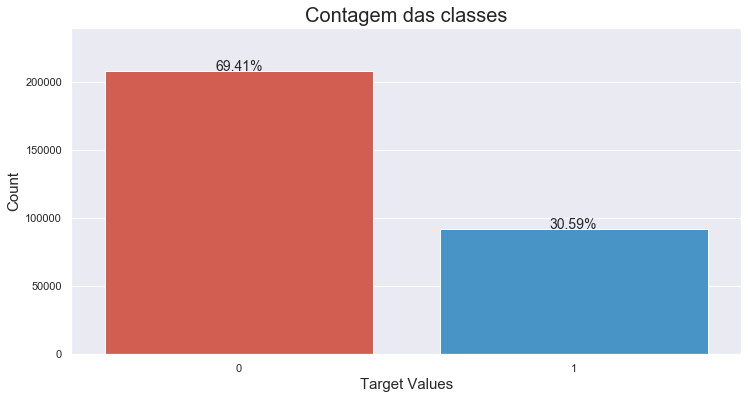

In [15]:
total = len(df_train)

plt.figure(figsize=(12,6))

sns.set(style="darkgrid")
g = sns.countplot(x='target', data=df_train, palette=flatui)
g.set_title("Contagem das classes", fontsize = 20)
g.set_xlabel("Target Values", fontsize = 15)
g.set_ylabel("Count", fontsize = 15)
sizes=[]
# código para porcentagens em cada barra
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.15)

plt.show()

O que observamos é que os dados não são tão desbalanceados:

- **69,41%** pertence a classe 0
- **30,59%** pertence a classe 1

## Visualizações: Binárias

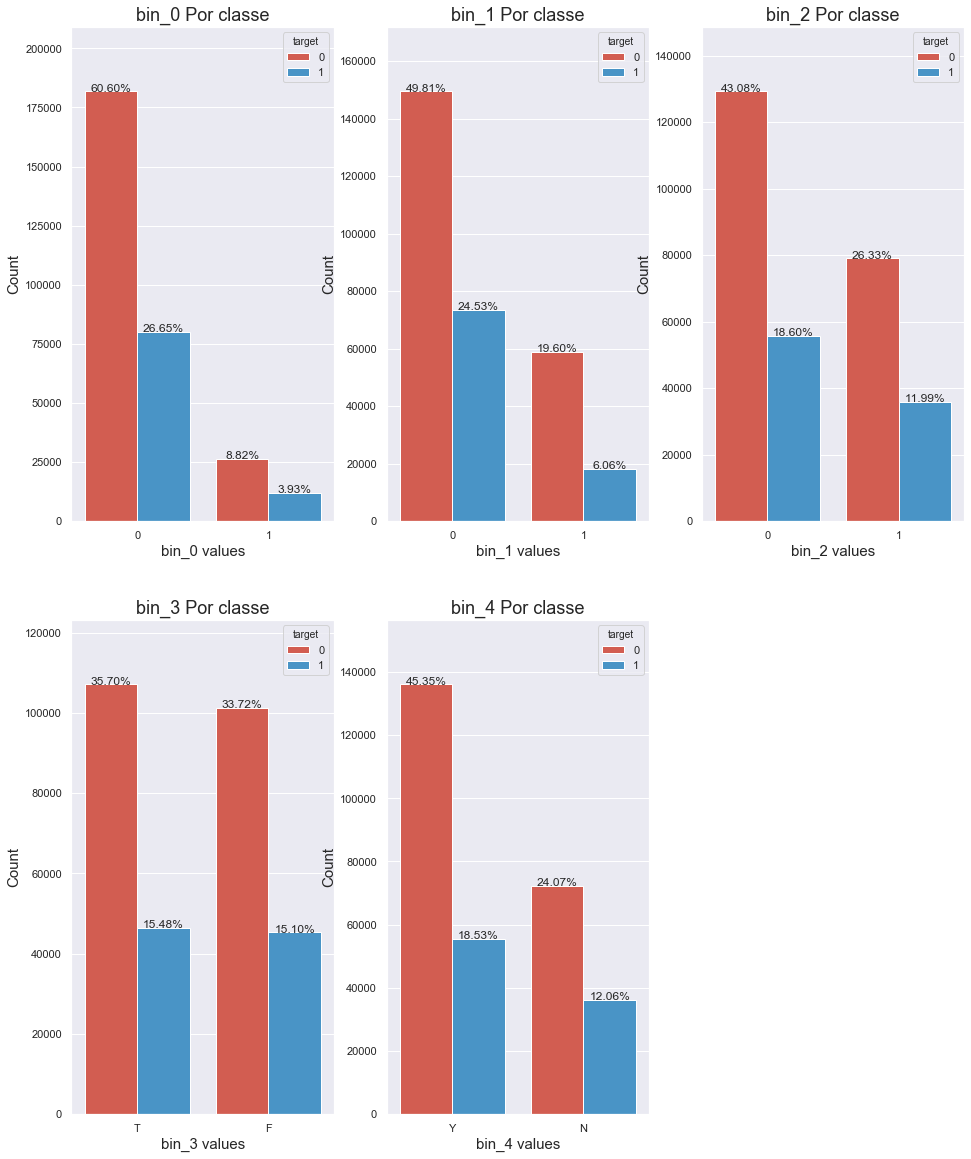

In [16]:
# vamos fazer um grid
# temos 5 variáveis binárias, logo uma iremos
# plotar em 2 linhas e 3 colunas.
grid = gridspec.GridSpec(2, 3)
plt.figure(figsize=(16,20))

# queremos um countplot, em cada variável binária
# por isso o loop for
bin_cols = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4']
for n, col in enumerate(df_train[bin_cols]): 
    ax = plt.subplot(grid[n])
    sns.countplot(x=col, data=df_train, hue='target', palette=flatui) 
    ax.set_ylabel('Count', fontsize=15)
    ax.set_title(f'{col} Por classe', fontsize=18)
    ax.set_xlabel(f'{col} values', fontsize=15)
    sizes=[]
    # código para porcentagens em cada barra
    for p in ax.patches:
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=12) 
    ax.set_ylim(0, max(sizes) * 1.15)
    
plt.show()

Vemos que as variáveis numéricas variam entre 3 tipos de classes:

- T/F
- Y/N
- 0/1

Novamente fica bem claro que os dados são relativamente bem balanceados, apenas variável _bin_1_ apresenta uma maior diferença entre as classes da variável target.


## Visualizações: Nominais

In [17]:
# nom_cols = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']
nom_cols = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']

In [18]:
def ploting_cat_fet(df, cols, vis_row=5, vis_col=2):
    sns.set(style="white")
    
    grid = gridspec.GridSpec(vis_row,vis_col) # The grid of chart
    plt.figure(figsize=(17, 35)) # size of figure

    # loop to get column and the count of plots
    for n, col in enumerate(df_train[cols]): 
        tmp = pd.crosstab(df_train[col], df_train['target'], normalize='index') * 100
        tmp = tmp.reset_index()
        tmp.rename(columns={0:'No',1:'Yes'}, inplace=True)

        ax = plt.subplot(grid[n]) # feeding the figure of grid
        sns.countplot(x=col, data=df_train, order=list(tmp[col].values), palette='Spectral') 
        ax.set_ylabel('Count', fontsize=15) # y axis label
        ax.set_title(f'{col} Por Classe', fontsize=18) # title label
        ax.set_xlabel(f'{col} values', fontsize=15) # x axis label

        # twinX - to build a second yaxis
        gt = ax.twinx()
        gt = sns.pointplot(x=col, y='Yes', data=tmp,
                           order=list(tmp[col].values),
                           color='black', legend=False)
        gt.set_ylim(tmp['Yes'].min()-5,tmp['Yes'].max()*1.1)
        gt.set_ylabel("Target %True(1)", fontsize=16)
        sizes=[] # Get highest values in y
        for p in ax.patches: # loop to all objects
            height = p.get_height()
            sizes.append(height)
            ax.text(p.get_x()+p.get_width()/2.,
                    height + 3,
                    '{:1.2f}%'.format(height/total*100),
                    ha="center", fontsize=14) 
        ax.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights


    plt.subplots_adjust(hspace = 0.5, wspace=.3)
    plt.show()

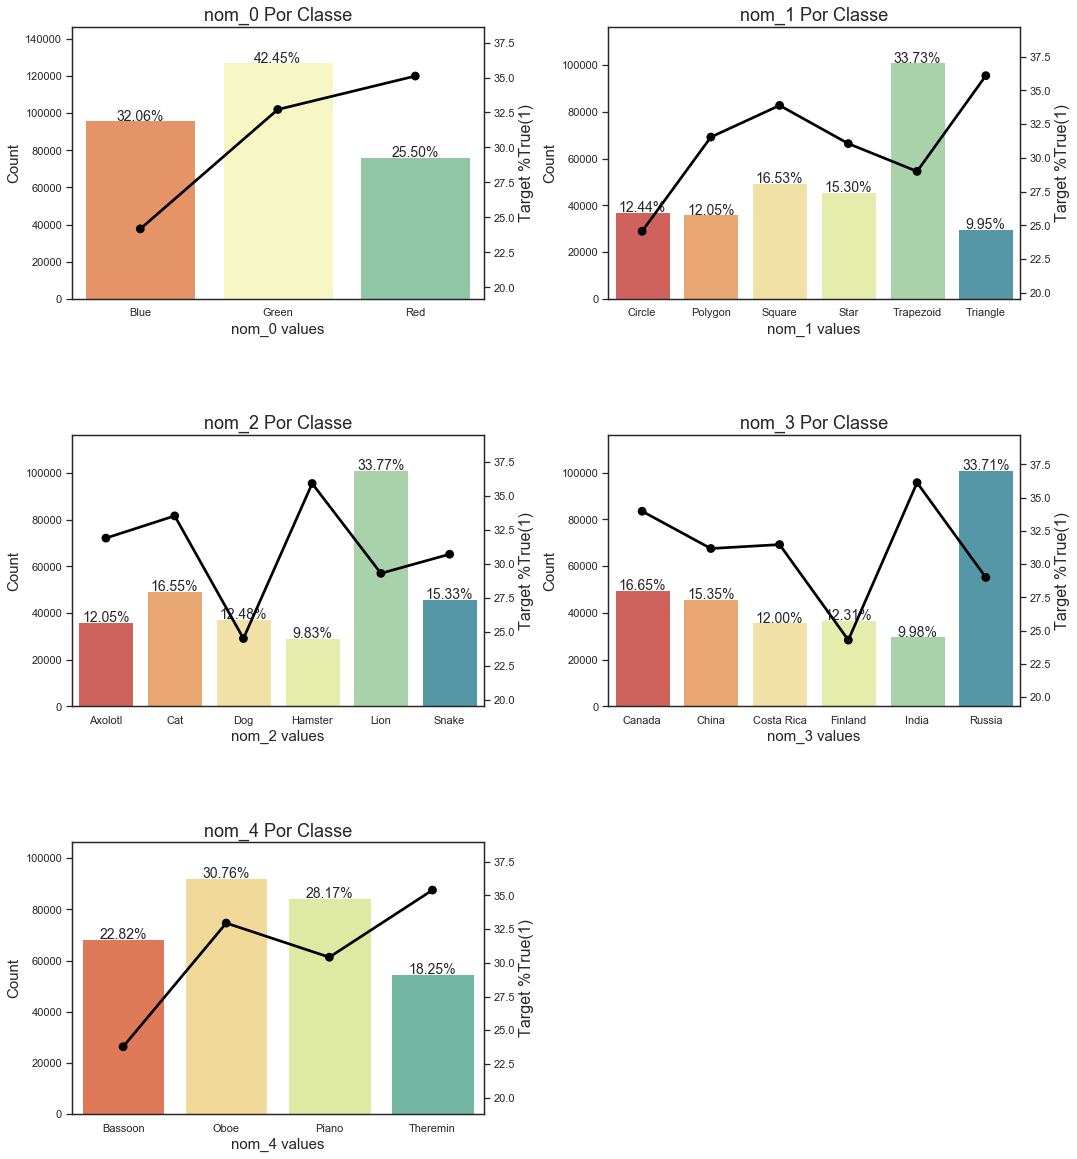

In [19]:
ploting_cat_fet(df_train, nom_cols, vis_row=5, vis_col=2)

Esse gráfico mescla 2 tipos diferentes de plots, o point plot com um gráfico de count plot, a intenção é mostrar o comportamento de algumas das variáveis nominais e a ocorrência de valores _True (1)_ na aquela variável.

É observado que a ocorrência de valores True é maior em classes de variáveis nominais que possuem menor ocorrência no grupo. 

Para variáveis nominais de alta cardinalidade (_nom_5_ a _nom_9_) se torna inviável de realizar o mesmo tipo de plot

## Visualização: Ordinais

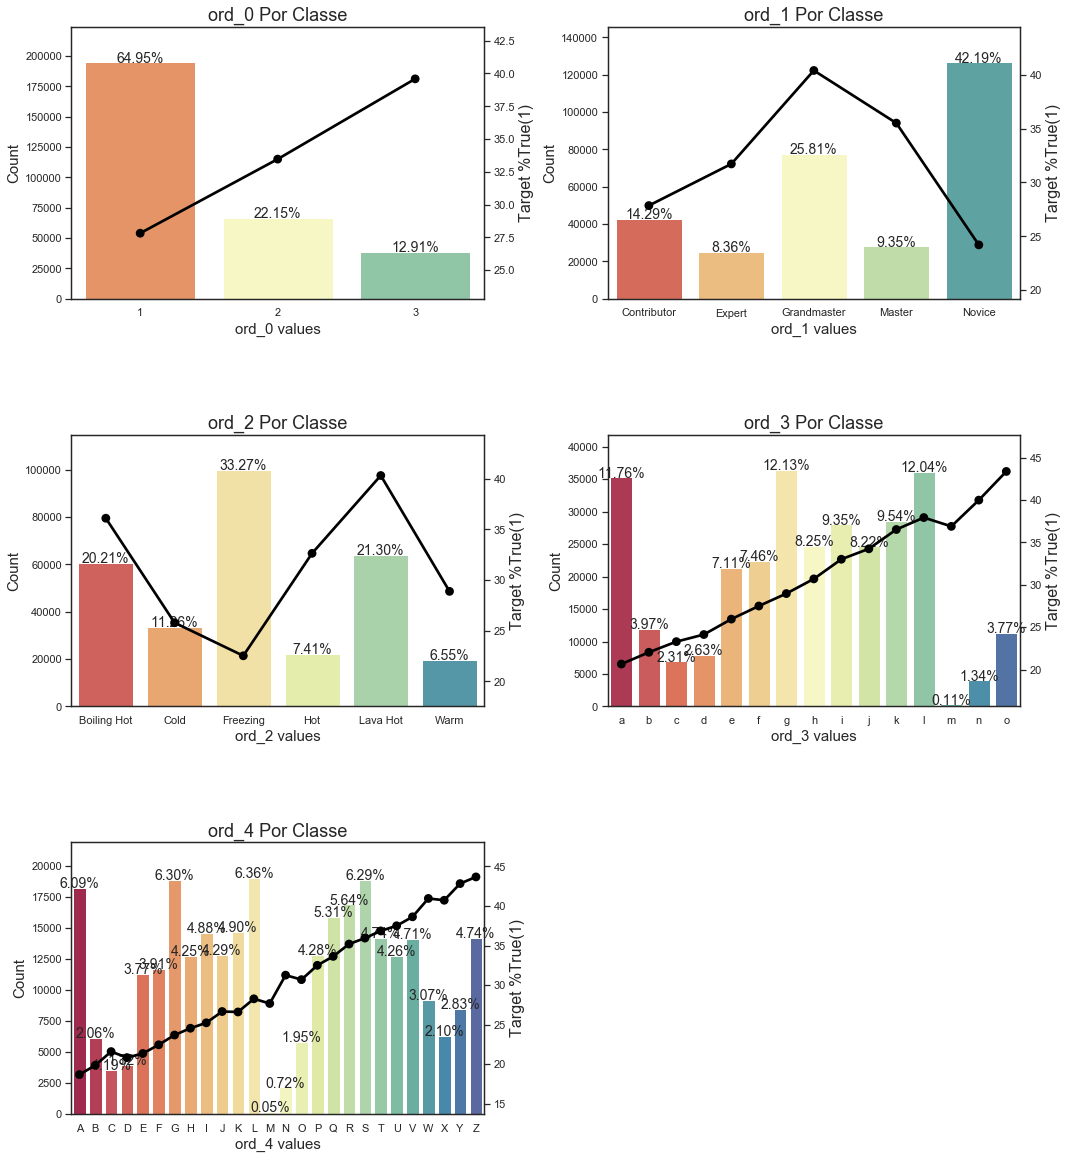

In [20]:
ord_cols = ['ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4']
ploting_cat_fet(df_train, ord_cols, vis_row=5, vis_col=2)

Muito interessante, como estamos tratando de variáveis ordinais, significa que cada ordem irá possuir um nível de importância. O que fica nítido ao visualizar ord_4 e ord_5, que estão ordenados de A a Z. 

O mesmo padrão também é visto em ord_0. Mas por que não vemos o mesmo comportamento em ord_1 e ord_2?

O motivo é que as variáveis não estão ordenadas pelo que de fato elas representam, e sim por ordem alfabética. Vamos visualizar então quando organizamos as variáveis ord_1 e ord_2 por uma ordem espécífica e para isso definimos algumas funções.

In [21]:
# Vamos definir algumas funções para conversão
def ord_to_fac(df, name, categories):
    '''
    A função converte para uma ordem específica
    de fatores.
    '''
    raw_cat = pd.Categorical(df[name], categories=categories, ordered=True)
    labels, unique = pd.factorize(raw_cat, sort=True)
    new_name = name + '_v2'
    df[new_name] = labels
    
def ord_to_num(name, df, categories):
    '''
    A função converte para ordem numérica ou
    alfabética.
    '''
    raw_cat = pd.Categorical(df[name], categories=categories, ordered=True)
    encoder = LabelEncoder()
    encoded = encoder.fit_transform(raw_cat)
    new_name = name + '_v2'
    df[new_name] = encoded

In [22]:
# Verificando as classes nas variáveis ordinais
unique_ord0 = df_train['ord_0'].unique()
unique_ord1 = df_train['ord_1'].unique()
unique_ord2 = df_train['ord_2'].unique()
unique_ord3 = df_train['ord_3'].unique()
unique_ord4 = df_train['ord_4'].unique()
unique_ord5 = df_train['ord_5'].unique()

In [23]:
name = 'ord_1'
categories = ['Novice', 'Contributor', 'Expert', 'Master', 'Grandmaster']
ord_to_fac(df_train, name, categories)

In [24]:
df_train.columns

Index(['id', 'bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1',
       'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
       'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month',
       'target', 'ord_1_v2'],
      dtype='object')

In [25]:
name = 'ord_2'
categories = ['Freezing', 'Cold', 'Warm', 'Hot', 'Boiling Hot', 'Lava Hot']
ord_to_fac(df_train, name, categories)

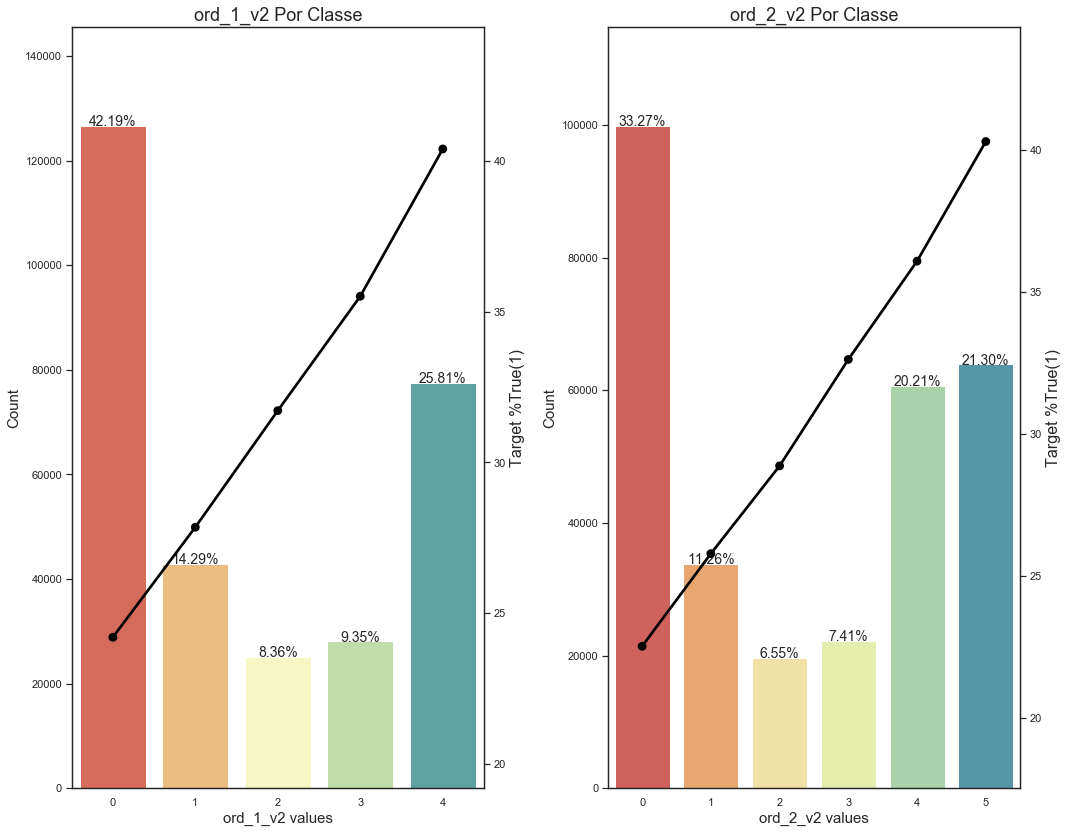

In [26]:
ord_cols = ['ord_1_v2', 'ord_2_v2']
ploting_cat_fet(df_train, ord_cols, vis_row=2, vis_col=2)

Muito bom, agora o padrão se torna nítido. Por último vamos observar a variável _ord_5_.

In [27]:
name = 'ord_5'
categories = ['AP', 'Ai', 'Aj', 'BA', 'BE', 'Bb', 'Bd', 'Bn', 'CL', 'CM', 'CU',
       'CZ', 'Cl', 'DH', 'DN', 'Dc', 'Dx', 'Ed', 'Eg', 'Er', 'FI', 'Fd',
       'Fo', 'GD', 'GJ', 'Gb', 'Gx', 'Hj', 'IK', 'Id', 'JX', 'Jc', 'Jf',
       'Jt', 'KR', 'KZ', 'Kf', 'Kq', 'LE', 'MC', 'MO', 'MV', 'Mf', 'Ml',
       'Mx', 'NV', 'Nf', 'Nk', 'OR', 'Ob', 'Os', 'PA', 'PQ', 'PZ', 'Ps',
       'QM', 'Qb', 'Qh', 'Qo', 'RG', 'RL', 'RP', 'Rm', 'Ry', 'SB', 'Sc',
       'TR', 'TZ', 'To', 'UO', 'Uk', 'Uu', 'Vf', 'Vx', 'WE', 'Wc', 'Wv',
       'XI', 'Xh', 'Xi', 'YC', 'Yb', 'Ye', 'ZR', 'ZS', 'Zc', 'Zq', 'aF',
       'aM', 'aO', 'aP', 'ac', 'av', 'bF', 'bJ', 'be', 'cA', 'cG', 'cW',
       'ck', 'cp', 'dB', 'dE', 'dN', 'dO', 'dP', 'dQ', 'dZ', 'dh', 'eG',
       'eQ', 'eb', 'eg', 'ek', 'ex', 'fO', 'fh', 'gJ', 'gM', 'hL', 'hT',
       'hh', 'hp', 'iT', 'ih', 'jS', 'jV', 'je', 'jp', 'kC', 'kE', 'kK',
       'kL', 'kU', 'kW', 'ke', 'kr', 'kw', 'lF', 'lL', 'll', 'lx', 'mb',
       'mc', 'mm', 'nX', 'nh', 'oC', 'oG', 'oH', 'oK', 'od', 'on', 'pa',
       'ps', 'qA', 'qJ', 'qK', 'qP', 'qX', 'qo', 'qv', 'qw', 'rZ', 'ri',
       'rp', 'sD', 'sV', 'sY', 'sn', 'su', 'tM', 'tP', 'tv', 'uJ', 'uS',
       'ud', 'us', 'ut', 'ux', 'uy', 'vK', 'vq', 'vy', 'wu', 'wy', 'xP',
       'xy', 'yN', 'yY', 'yc', 'zU']
ord_to_num(name, df_train, categories)

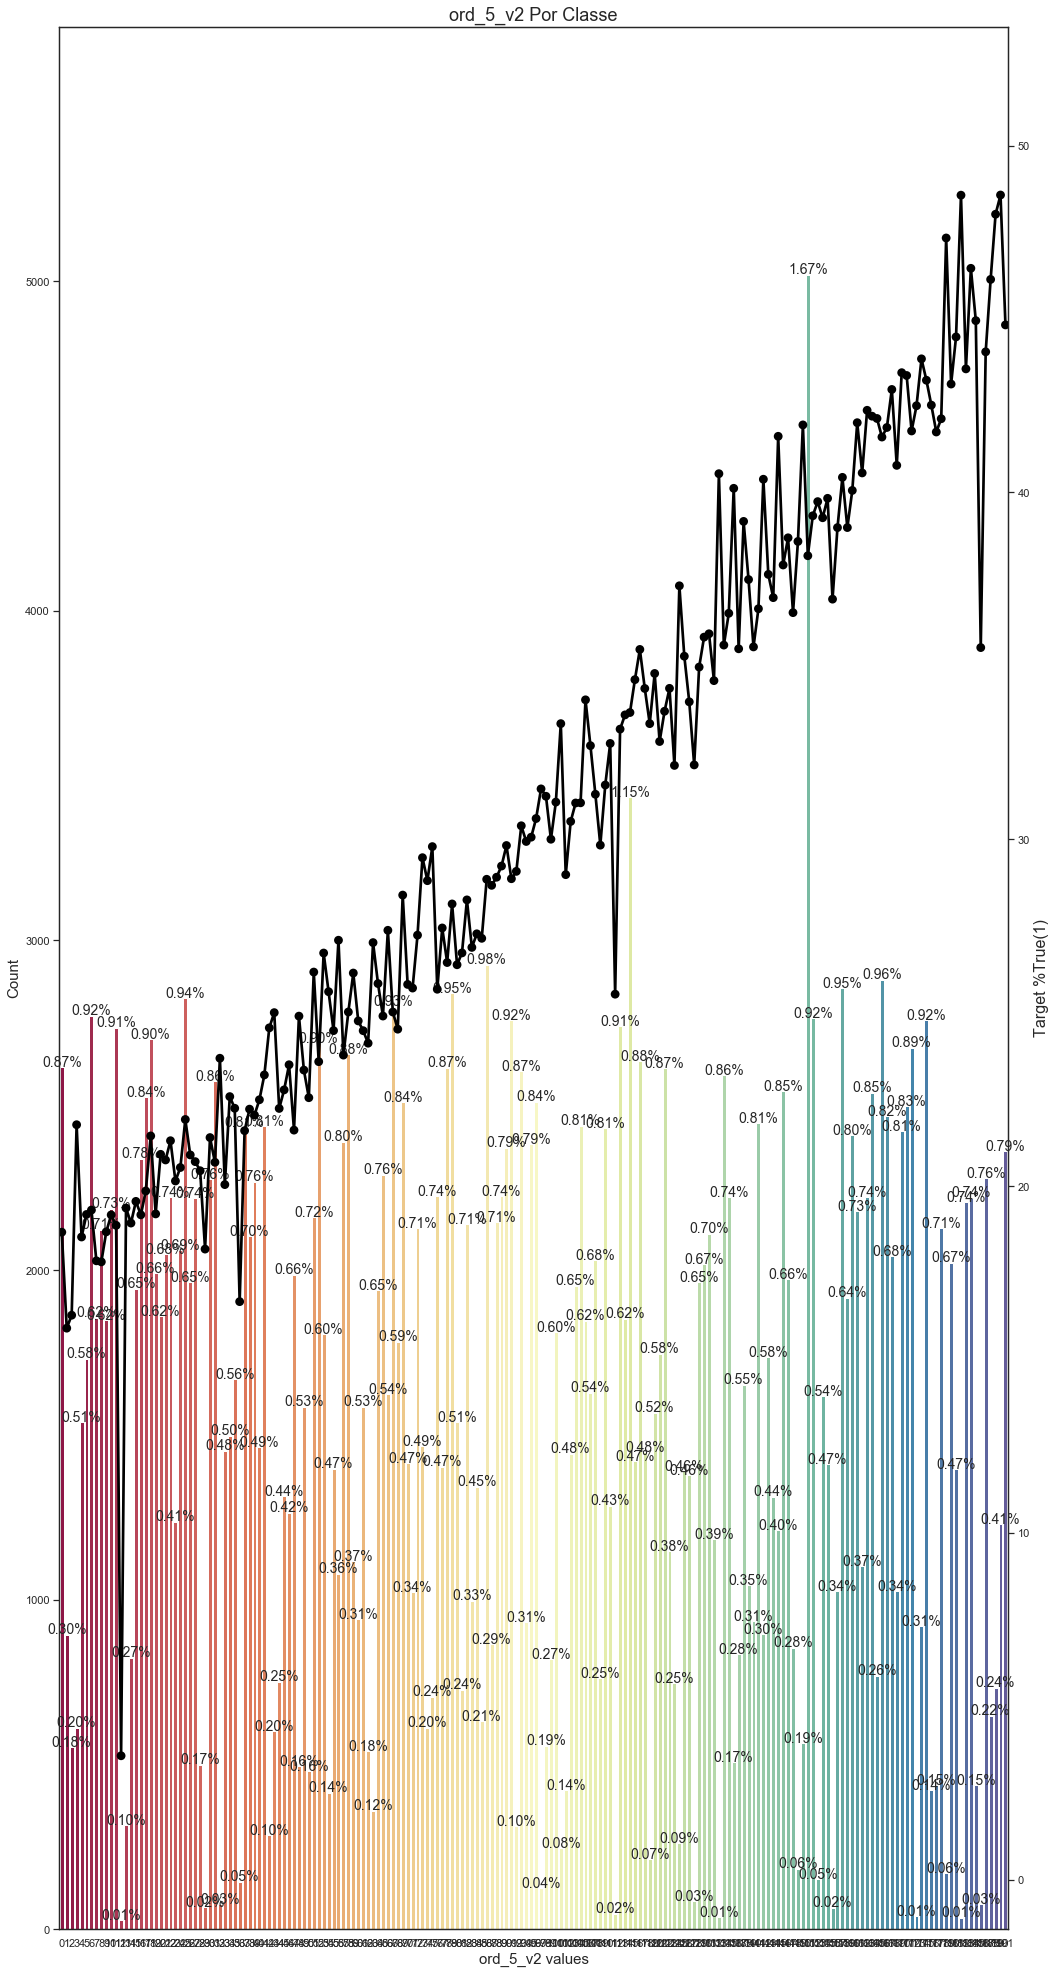

In [28]:
ord_cols = ['ord_5_v2']
ploting_cat_fet(df_train, ord_cols, vis_row=1, vis_col=1)

O que observamos é que as classes da variável _ord_5_ não possuem o comportamento tão linear quanto as outras variáveis ordinais. Nos levando a duas hipóteses:

- Ou a variável é resultado de combinação de variáveis, que acabou proporcionando esse ruído observado.
- Ou ela realmente possui (intrinsecamente) esse ruído, e não teríamos muito oq fazer.

Podemos então testar a primeira suposição, e realizar a separação da _ord_5_ em novas duas variáveis. Onde a primeira coluna diz respeito ao primeiro caractere de cada amostra, e a segunda coluna ao segundo caractere de cada amostra.

In [29]:
# Iremos considerar que a variável ord_5 foi resultado da junção de 2 outras
# sendo um caractere oriundo de uma variável e o outro de outra.
# Dessa forma separaremos cada elemento da ord_5 do dataset.
categories = ['AP', 'Ai', 'Aj', 'BA', 'BE', 'Bb', 'Bd', 'Bn', 'CL', 'CM', 'CU',
       'CZ', 'Cl', 'DH', 'DN', 'Dc', 'Dx', 'Ed', 'Eg', 'Er', 'FI', 'Fd',
       'Fo', 'GD', 'GJ', 'Gb', 'Gx', 'Hj', 'IK', 'Id', 'JX', 'Jc', 'Jf',
       'Jt', 'KR', 'KZ', 'Kf', 'Kq', 'LE', 'MC', 'MO', 'MV', 'Mf', 'Ml',
       'Mx', 'NV', 'Nf', 'Nk', 'OR', 'Ob', 'Os', 'PA', 'PQ', 'PZ', 'Ps',
       'QM', 'Qb', 'Qh', 'Qo', 'RG', 'RL', 'RP', 'Rm', 'Ry', 'SB', 'Sc',
       'TR', 'TZ', 'To', 'UO', 'Uk', 'Uu', 'Vf', 'Vx', 'WE', 'Wc', 'Wv',
       'XI', 'Xh', 'Xi', 'YC', 'Yb', 'Ye', 'ZR', 'ZS', 'Zc', 'Zq', 'aF',
       'aM', 'aO', 'aP', 'ac', 'av', 'bF', 'bJ', 'be', 'cA', 'cG', 'cW',
       'ck', 'cp', 'dB', 'dE', 'dN', 'dO', 'dP', 'dQ', 'dZ', 'dh', 'eG',
       'eQ', 'eb', 'eg', 'ek', 'ex', 'fO', 'fh', 'gJ', 'gM', 'hL', 'hT',
       'hh', 'hp', 'iT', 'ih', 'jS', 'jV', 'je', 'jp', 'kC', 'kE', 'kK',
       'kL', 'kU', 'kW', 'ke', 'kr', 'kw', 'lF', 'lL', 'll', 'lx', 'mb',
       'mc', 'mm', 'nX', 'nh', 'oC', 'oG', 'oH', 'oK', 'od', 'on', 'pa',
       'ps', 'qA', 'qJ', 'qK', 'qP', 'qX', 'qo', 'qv', 'qw', 'rZ', 'ri',
       'rp', 'sD', 'sV', 'sY', 'sn', 'su', 'tM', 'tP', 'tv', 'uJ', 'uS',
       'ud', 'us', 'ut', 'ux', 'uy', 'vK', 'vq', 'vy', 'wu', 'wy', 'xP',
       'xy', 'yN', 'yY', 'yc', 'zU']

ord_5_v3 = []
ord_5_v4 = []
for i in df_train['ord_5']:
    lista = list(i)
    ord_5_v3.append(i[0])
    ord_5_v4.append(i[1])
    
df_train['ord_5_v3'] = ord_5_v3
df_train['ord_5_v4'] = ord_5_v4

In [30]:
df_train.columns

Index(['id', 'bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1',
       'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
       'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month',
       'target', 'ord_1_v2', 'ord_2_v2', 'ord_5_v2', 'ord_5_v3', 'ord_5_v4'],
      dtype='object')

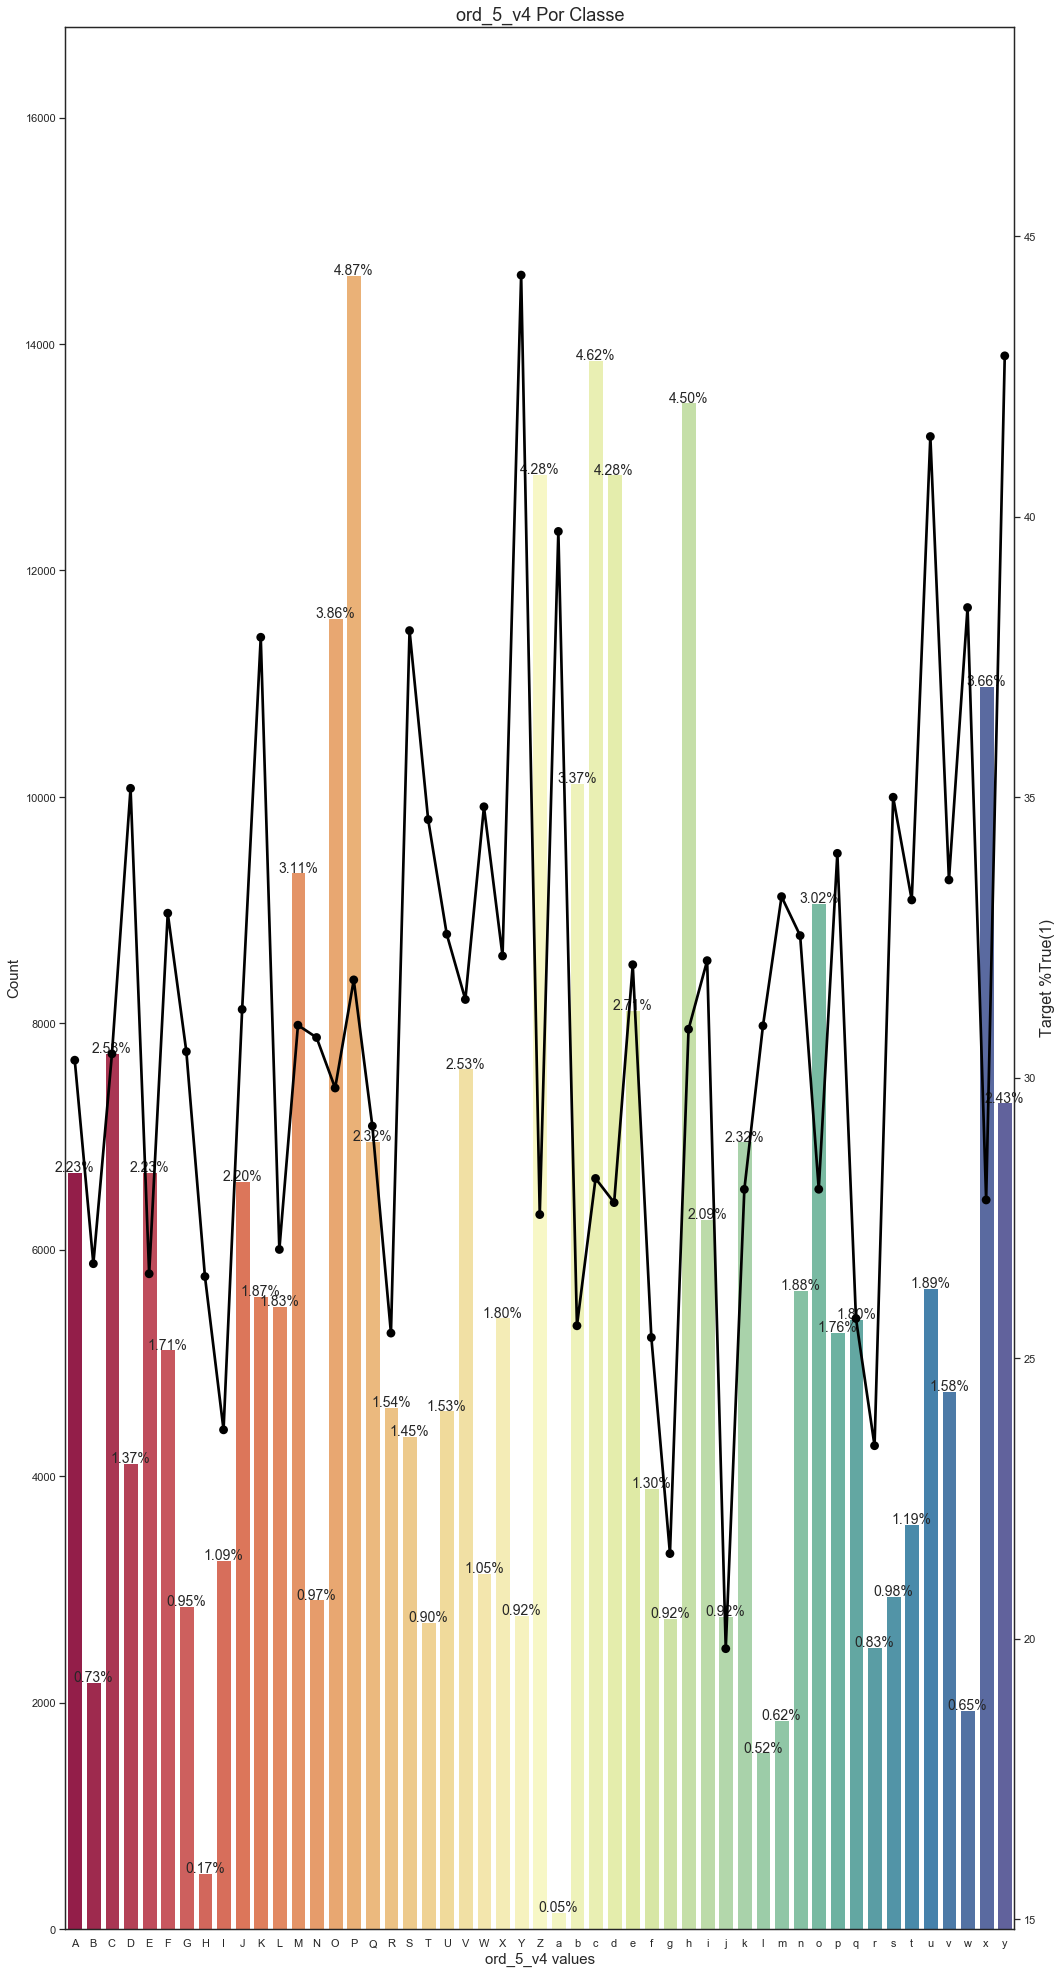

In [31]:
ord_cols = ['ord_5_v4']
ploting_cat_fet(df_train, ord_cols, vis_row=1, vis_col=1)

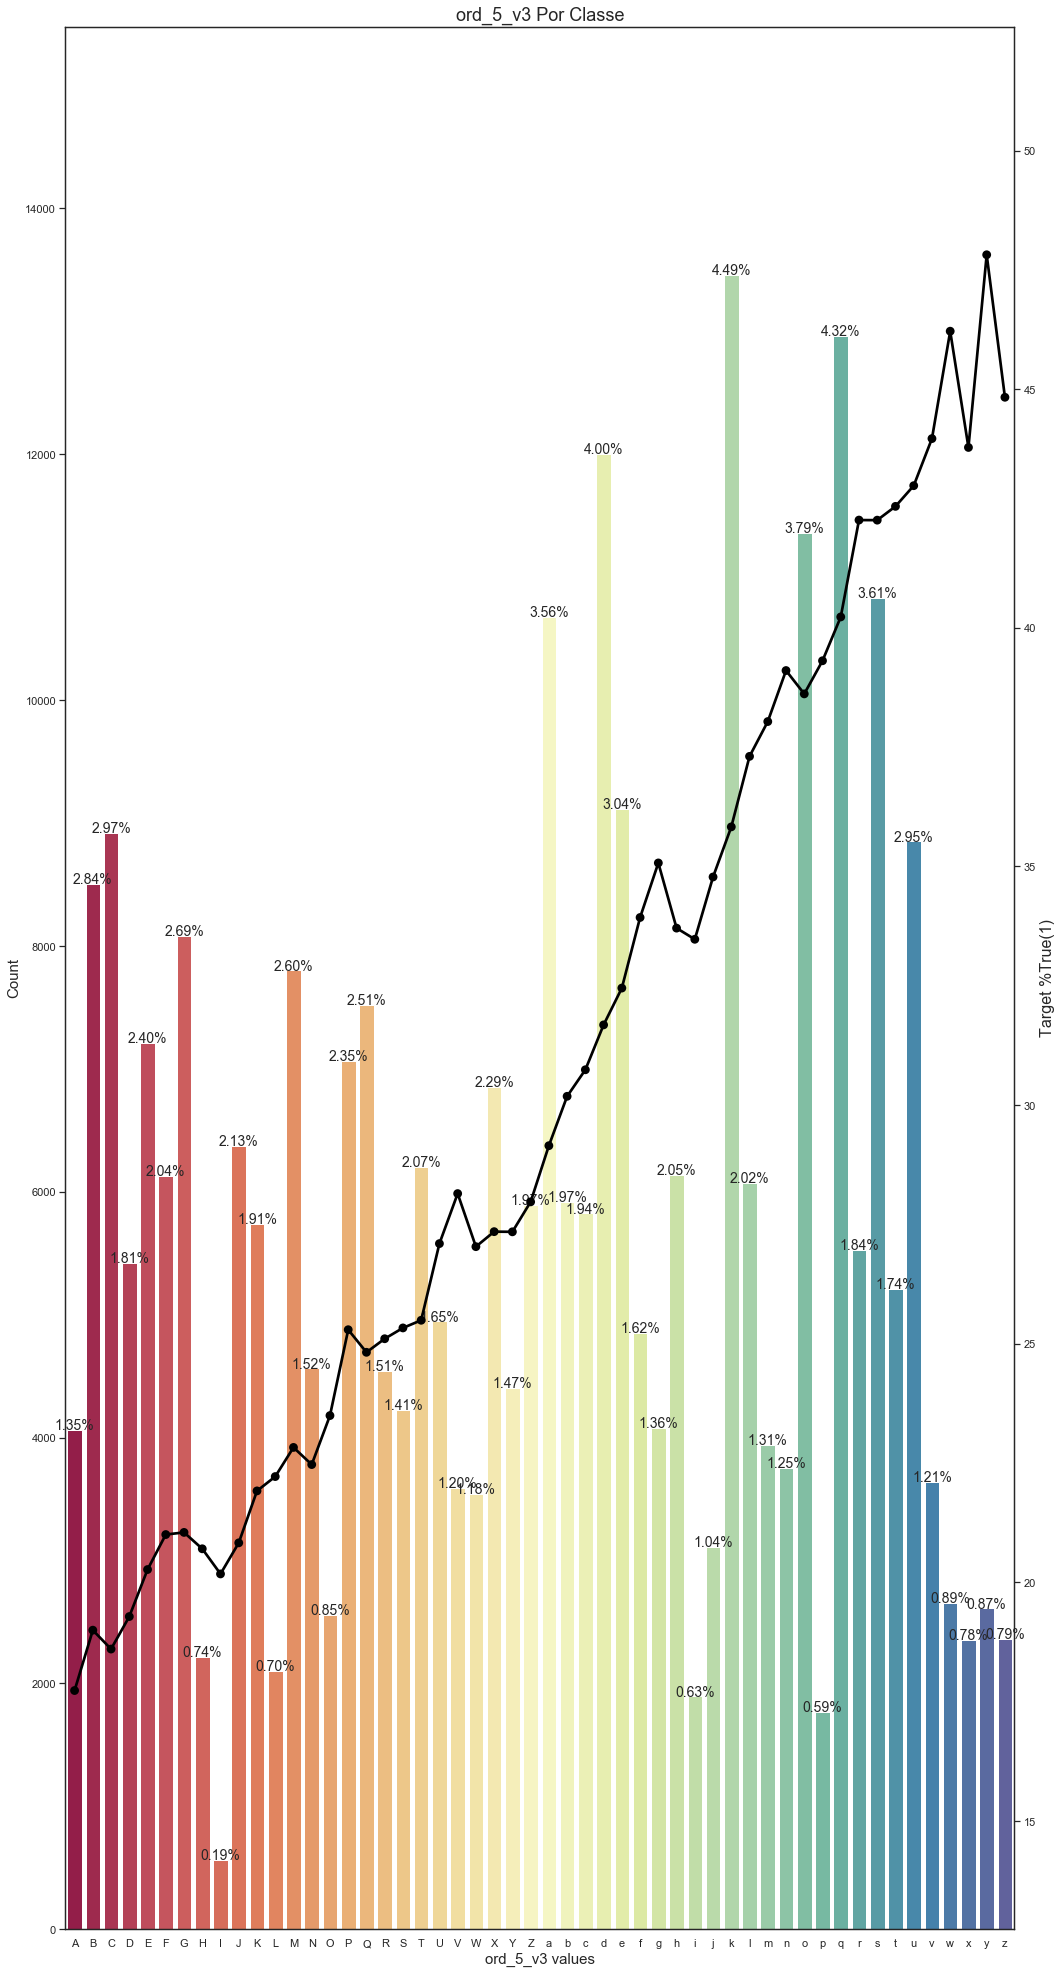

In [32]:
ord_cols = ['ord_5_v3']
ploting_cat_fet(df_train, ord_cols, vis_row=1, vis_col=1)

Incrível! Vemos que ao separar a variável _ord_5_ em duas, uma delas mostrou um padrão muito mais linear que a original. E que a outra variável criada apresenta apenas ruído.

# Visualização: Data

Temos no dataset algumas variáveis de data. Uma representando alguns meses do ano e a outra os dias da semana.

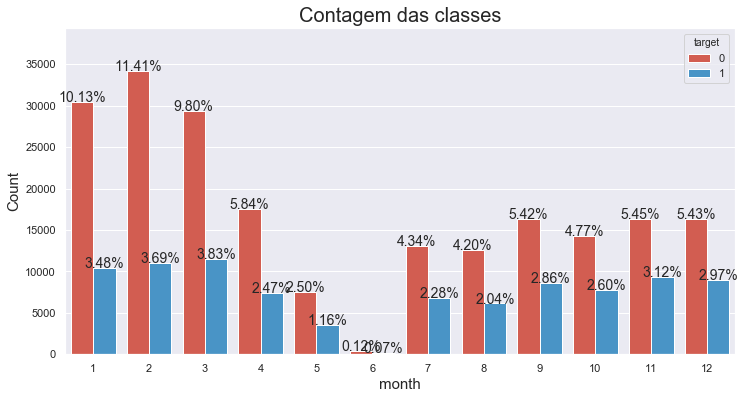

In [33]:
total = len(df_train)

plt.figure(figsize=(12,6))

sns.set(style="darkgrid")
g = sns.countplot(x='month', hue='target', data=df_train, palette=flatui)
g.set_title("Contagem das classes", fontsize = 20)
g.set_xlabel("month", fontsize = 15)
g.set_ylabel("Count", fontsize = 15)
sizes=[]
# código para porcentagens em cada barra
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.15)

plt.show()

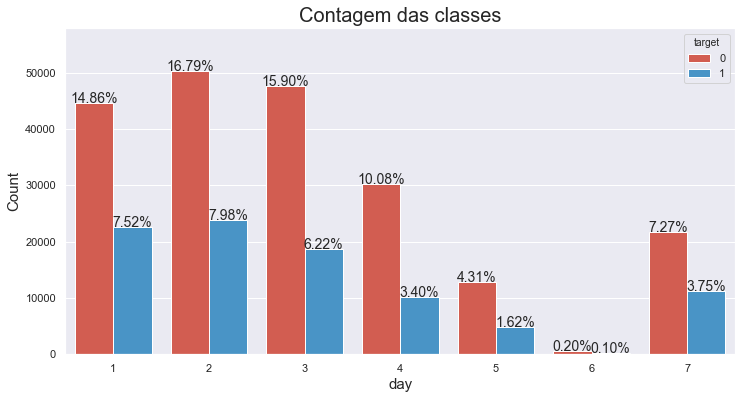

In [34]:
total = len(df_train)

plt.figure(figsize=(12,6))

sns.set(style="darkgrid")
g = sns.countplot(x='day', hue='target', data=df_train, palette=flatui)
g.set_title("Contagem das classes", fontsize = 20)
g.set_xlabel("day", fontsize = 15)
g.set_ylabel("Count", fontsize = 15)
sizes=[]
# código para porcentagens em cada barra
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.15)

plt.show()

Uma observação, apesar de ser irrelevante, é que o dia 6 e o mês 6 apresentaram a menor ocorrência de 0 e 1. A distribuição de valores do target, ao longo das datas não apresentam muito desbalanceamento, permanecendo dentro do que vem sendo observado.

Começaremos agora o pré-processamento dos dados, onde será tratado cada tipo das variáveis (binária, ordinal, nominal e data).

In [35]:
# para evitar de não identificar alguma classe nos dados
# vamos trabalhar com os dois dataset juntos, depois iremos separar na etapa de machine learning.
df = pd.concat([train, test], axis=0)

# Tratamento de variáveis ordinais

Aqui aplicaremos 2 principais técnicas de tratamento de variáveis categóricas. O Label Encoder e o One Hot Encoder disponíveis no Scikit Learn e no Pandas, respectivamente.

In [36]:
# Como foi informado que possuímos variáveis ordinais
# faz sentido que a var_7 tenha mais importância que a var_0.
# Vamos definir algumas funções para conversão
def ord_to_fac(df, name, categories):
    '''
    A função converte para uma ordem específica
    de fatores.
    '''
    raw_cat = pd.Categorical(df[name], categories=categories, ordered=True)
    labels, unique = pd.factorize(raw_cat, sort=True)
    new_name = name + '_v2'
    df[new_name] = labels
    
def ord_to_num(name, df, categories):
    '''
    A função converte para ordem numérica ou
    alfabética.
    '''
    raw_cat = pd.Categorical(df[name], categories=categories, ordered=True)
    encoder = LabelEncoder()
    encoded = encoder.fit_transform(raw_cat)
    new_name = name + '_v2'
    df[new_name] = encoded

In [37]:
# Verificando as classes nas variáveis ordinais
unique_ord0 = df['ord_0'].unique()
unique_ord1 = df['ord_1'].unique()
unique_ord2 = df['ord_2'].unique()
unique_ord3 = df['ord_3'].unique()
unique_ord4 = df['ord_4'].unique()
unique_ord5 = df['ord_5'].unique()

In [38]:
name = 'ord_1'
categories = ['Novice', 'Contributor', 'Expert', 'Master', 'Grandmaster']
ord_to_fac(df, name, categories)

In [39]:
name = 'ord_2'
categories = ['Freezing', 'Cold', 'Warm', 'Hot', 'Boiling Hot', 'Lava Hot']
ord_to_fac(df, name, categories)

In [40]:
name = 'ord_3'
categories = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o']
ord_to_num(name, df, categories)

In [41]:
name = 'ord_4'
categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
ord_to_num(name, df, categories)

In [42]:
ord_5_v3 = []
ord_5_v4 = []
for i in df['ord_5']:
    lista = list(i)
    ord_5_v3.append(i[0])
    ord_5_v4.append(i[1])

df['ord_5_v3'] = ord_5_v3

In [43]:
name = 'ord_5_v3'
categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
ord_to_num(name, df, categories)

In [44]:
df.columns

Index(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2',
       'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0',
       'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month', 'ord_1_v2',
       'ord_2_v2', 'ord_3_v2', 'ord_4_v2', 'ord_5_v3', 'ord_5_v3_v2'],
      dtype='object')

# Tratamento de variáveis binárias

As variáveis _bin_0_, _bin_1_ e _bin_2_ já possuem valores numéricos, então iremos apenas substituir das variáveis _bin_3_ e _bin_4_.

In [45]:
unique_bin3 = df['bin_3'].unique()
unique_bin4 = df['bin_4'].unique()

In [46]:
name = 'bin_3'
categories = ['T', 'F']
ord_to_num(name, df, categories)

In [47]:
name = 'bin_4'
categories = ['Y', 'N']
ord_to_num(name, df, categories)

# Tratando variáveis cíclicas

### Temos dia da semana e meses do ano

Para os meses do ano, o mais indicado é que se divida os dados em trimestres. Aos quais as novas variáveis serão: _Q1_, _Q2_, _Q3_, _Q4_.

In [48]:
df['quarters'] = pd.to_datetime(df['month'].values, format='%m').astype('period[Q]')
df_month = pd.get_dummies(df['quarters'], prefix='v2', drop_first=False)
df = pd.concat([df, df_month], axis=1)

# Drop de algumas colunas

In [49]:
df.columns

Index(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2',
       'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0',
       'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month', 'ord_1_v2',
       'ord_2_v2', 'ord_3_v2', 'ord_4_v2', 'ord_5_v3', 'ord_5_v3_v2',
       'bin_3_v2', 'bin_4_v2', 'quarters', 'v2_1900Q1', 'v2_1900Q2',
       'v2_1900Q3', 'v2_1900Q4'],
      dtype='object')

In [50]:
# para não perder o progresso no dataset original por algum comando
new_df = df.copy()

In [51]:
new_df.drop(['bin_3', 'bin_4', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'month', 'quarters', 'ord_5_v3'], axis=1, inplace=True)

In [52]:
new_df.columns

Index(['bin_0', 'bin_1', 'bin_2', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4',
       'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0', 'day', 'ord_1_v2',
       'ord_2_v2', 'ord_3_v2', 'ord_4_v2', 'ord_5_v3_v2', 'bin_3_v2',
       'bin_4_v2', 'v2_1900Q1', 'v2_1900Q2', 'v2_1900Q3', 'v2_1900Q4'],
      dtype='object')

# Iniciando a criação da matriz esparsa

Como iremos aplicar o one hot encoder em toda a matriz, a quantidade de memória utilizada é extremamente grande. Para minimizar isso podemos realizar a criação de uma matriz esparsa, que justamente é especializada no armazenamento de uma matriz que possui grande quantidades de zeros com valores esparssados ao longo de sua dimensão.

Para isso, o Pandas possui o _get_dummies_ com o parâmetro _sparse_, que precisa receber o valor **True**.

In [53]:
columns = [i for i in new_df.columns]
print(columns)

['bin_0', 'bin_1', 'bin_2', 'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0', 'day', 'ord_1_v2', 'ord_2_v2', 'ord_3_v2', 'ord_4_v2', 'ord_5_v3_v2', 'bin_3_v2', 'bin_4_v2', 'v2_1900Q1', 'v2_1900Q2', 'v2_1900Q3', 'v2_1900Q4']


In [54]:
dummies = pd.get_dummies(new_df, columns=columns, drop_first=True, sparse=True)

In [55]:
dummies.shape

(500000, 16382)

In [56]:
train = dummies.iloc[:train.shape[0], :]
test = dummies.iloc[train.shape[0]:, :]

In [57]:
# preenchemos os NAs com 0, pois fica complicado verificar se existe valor nulo 
# devido a dimens
train = train.fillna(0)
train.head(5)

,bin_0_1,bin_1_1,bin_2_1,nom_0_Green,nom_0_Red,nom_1_Polygon,nom_1_Square,nom_1_Star,nom_1_Trapezoid,nom_1_Triangle,...,ord_5_v3_v2_48,ord_5_v3_v2_49,ord_5_v3_v2_50,ord_5_v3_v2_51,bin_3_v2_1,bin_4_v2_1,v2_1900Q1_1,v2_1900Q2_1,v2_1900Q3_1,v2_1900Q4_1
0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,1,1,0,0,0
1,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,1,1,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0
3,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0
4,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [58]:
train = train.sparse.to_coo().tocsr()
test = test.sparse.to_coo().tocsr()

# Modelagem Preditiva

In [59]:
seed = 7
cv_size = 0.30
X_train, X_cv, y_train, y_cv = train_test_split(train, y, test_size=cv_size, random_state=seed)

In [61]:
model = XGBClassifier()
model.fit(X_train, y_train)
prediction = model.predict_proba(X_cv)[:, 1]
roc_score = roc_auc_score(y_cv, prediction)
print(roc_score)

0.7631479991590155


In [62]:
lr_cv = LogisticRegressionCV(Cs=7,
                        solver="lbfgs",
                        tol=0.0002,
                        max_iter=10000,
                        cv=5,
                        n_jobs=6)

lr_cv.fit(train, y)

lr_cv_pred = lr_cv.predict_proba(train)[:, 1]
score = roc_auc_score(y, lr_cv_pred)

print("score: ", score)

score:  0.8177916253269919


O melhor score encontrado foi do método utilizando a Regressão Logística, que teve um comportamento fantástico sendo que processou dados de 16 mil colunas com um score de 81,78% na métrica AUC utilizada para avaliação do modelo.

# Geração do arquivo de Submissão ao Kaggle

In [63]:
submission["id"] = test_id
submission["target"] = lr_cv.predict_proba(test)[:, 1]

In [64]:
submission.head()

,id,target
0,300000,0.326448
1,300001,0.688898
2,300002,0.149882
3,300003,0.390202
4,300004,0.845298


In [65]:
submission.to_csv("submission_verX.csv", index=False)

# Conclusões

Logicamente que esses dados possuem uma caracteristica bastante acentuada, que é de ser composto apenas de dados categóricos e ainda com algumas colunas possuíndo mais de 11 mil valores únicos. Na realidade é possivel que não encontremos uma base de dados tão peculiar no dia a dia, mas as skills desenvolvidas aqui continuam sendo válidas para a resolução de diversos problemas.